<a href="https://colab.research.google.com/github/rubygitflow/Trading-strategy/blob/main/University_of_Artificial_Intelligence_Competition_%22Trading%22_v_1_7_(90_20_Hybrid)_Risk_it_(False_True)_traiding_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Блок загрузки**

In [ ]:
import importlib.util, sys, gdown
import matplotlib.pyplot as plt # Отрисовка графиков
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики
import numpy as np 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #Стандартные слои

from google.colab import drive # Подключаем гугл-диск

In [ ]:
drive.mount('/content/drive')

In [ ]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

In [ ]:
!unzip -q data.zip -d ''

## **Основной блок**

In [ ]:
import utils # Подключаем набор функций

### **Подключение к данным**

In [ ]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

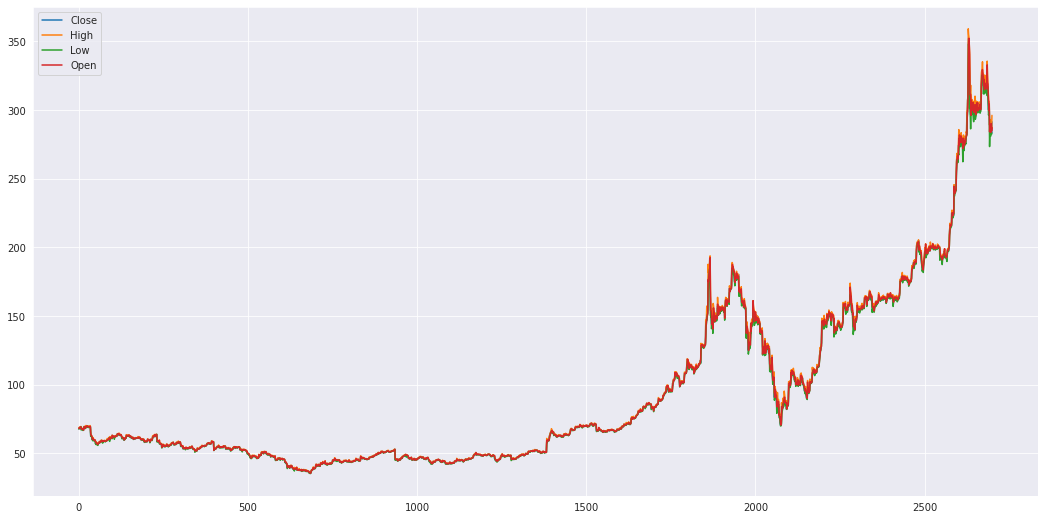

In [ ]:
utils.show_data(train_dataset, start=0, end=0, param=['Close','High','Low','Open']) # Визуализируем обучающий датасет

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

In [ ]:
# Здесь заглушка для отсутствующего тестового датасета
test_dataset = val_dataset.copy()

### **Предсказание цены и тренда на несколько шагов вперёд**

#### **Подготовка датасета**

К вопросу именования выборок — Обучающая, Валидационная, Тестовая: 

[Перевод книги Эндрю Ына «Страсть к машинному обучению»](https://habr.com/ru/post/419757/)

In [ ]:
class DerivativeData:
  """
  Класс для параметризации временного ряда

  Подготовка параметрической выборки данных, полученных из входного 
  распределения данных 'Open', 'Max', 'Min', 'Close'
  Собираем расширенные данные под новый инпут:
  — 4 Первые производные каналов:       (x[n] - x[n-1])
  — 4 Вторые производные каналов:       (x[n] - 2*x[n-1] + x[n-2])
  — 4 Третьи производные каналов:       (x[n] - 3*x[n-1] + 3*x[n-2] - x[n-3])
  — 4 Четвёртые производные каналов:    (x[n] - 4*x[n-1] + 6*x[n-2] - 4*x[n-3] + x[n-4])

  Собираем расширенные данные под новый аутпут: 
  — будущая цена Open: x[n+1]
  — смотрим на 4 шага вперёд
  вычисляем 1: Close[n+4] - Close[n]
  — для всех промежуточных значений 'Open', 'Max', 'Min', 'Close' по всем 5 точкам
  вычисляем 2: среднее арифметическое - (среднее - минимальное) = mean - (middle - min)
  """
  # Текстовые названия каналов данных
  chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

  def __init__(self, pandas_dataset, is_predict_test = False):
    self.dataset = pandas_dataset.values # конвертация в тип numpy array
    rb = 0 if is_predict_test else 4 # правая граница исходного массива 
    # отсекаем, если строим обучающую или валидационную выборку и 
    # не отсекаем данные, елси строим тестовую выборку для предсказания

    first_derivative_data = self._first_derivative(rb)
    second_derivative_data = self._second_derivative(rb)
    third_derivative_data = self._third_derivative(rb)
    fourth_derivative_data = self._fourth_derivative(rb)

    if rb == 0:
      self.derivativeset = np.hstack(( 
                                      self.dataset[4:],
                                      first_derivative_data, 
                                      second_derivative_data, 
                                      third_derivative_data, 
                                      fourth_derivative_data
                                    ))
    else:
      self.derivativeset = np.hstack(( 
                                      self.dataset[4:-rb],
                                      first_derivative_data, 
                                      second_derivative_data, 
                                      third_derivative_data, 
                                      fourth_derivative_data
                                    ))
    print('self.derivativeset.shape', self.derivativeset.shape)

    self.x = self.derivativeset # ненормализованный входной массив

    if rb == 0:
      close_data = self._close_derivative(rb)
      average_movement_data = self._average_movement(rb)
      print('close_data.shape = ',close_data.shape, 
            'average_movement_data.shape = ',average_movement_data.shape)
      self.trendset = np.hstack(( 
                                np.reshape(self.dataset[4:,0],(-1,1)),
                                close_data, 
                                average_movement_data
                              ))
    else:
      close_data = self._close_derivative(rb)
      average_movement_data = self._average_movement(rb)
      print('close_data.shape = ',close_data.shape, 
            'average_movement_data.shape = ',average_movement_data.shape)
      self.trendset = np.hstack(( 
                                np.reshape(self.dataset[4:-4,0],(-1,1)),
                                close_data, 
                                average_movement_data
                              ))
    self.y = self.trendset  # ненормализованный выходной массив

    self.dataGen = None # набор данных скользящих окон по таймсериям

  def draw_time_series(self):
    # Отрисовываем четыре основных канала - open, max, min, close
    plt.figure(figsize=(21, 5))
    for i in range(4):
      plt.plot(self.x[:,i], label=self.chanelNames[i])
    plt.ylabel('Цена.руб')
    plt.legend()
    plt.show()

  def draw_time_volumes(self):
    # Отрисовываем канал volume
    plt.figure(figsize=(21, 5))
    plt.plot(self.x[:,4], label=self.chanelNames[4])
    plt.ylabel('Объём.шт')
    plt.legend()
    plt.show()

  def normalize_x(self, scaler):  # нормализация входного массива по заданной функции
    self.x =  scaler.transform(self.x)
    return self.x

  def normalize_y(self, scaler):  # нормализация выходного массива по заданной функции
    self.y =  scaler.transform(self.y)
    return self.y

  def timeseries_generator(self, xLen, batchSize): # генерации батчей временных данных
    # xLen      — Длина выходных последовательностей (по количеству временных интервалов)
    # batchSize — Размер пакета — Количество сэмплов таймсерий в каждой партии (за исключением, возможно, последней)
    self.dataGen = TimeseriesGenerator(
                                      self.x, self.y,          
                                      length=xLen, sampling_rate=1,
                                      batch_size=batchSize
                                      )   
    return self.dataGen  
  
  def _first_derivative(self, rb):
    derivative = []
    for i in range(4, self.dataset.shape[0]-rb):
      derivative.append(self.dataset[i] - self.dataset[i-1])
    return np.array(derivative)
  
  def _second_derivative(self, rb):
    derivative = []
    for i in range(4, self.dataset.shape[0]-rb):
      derivative.append(self.dataset[i] - 2*self.dataset[i-1] + 
                        self.dataset[i-2])
    return np.array(derivative)

  def _third_derivative(self, rb):
    derivative = []
    for i in range(4, self.dataset.shape[0]-rb):
      derivative.append(self.dataset[i] - 3*self.dataset[i-1] + 
                        3*self.dataset[i-2] - self.dataset[i-3])
    return np.array(derivative)

  def _fourth_derivative(self, rb):
    derivative = []
    for i in range(4, self.dataset.shape[0]-rb):
      derivative.append(self.dataset[i] - 4*self.dataset[i-1] + 
                        6*self.dataset[i-2] - 4*self.dataset[i-3] + 
                        self.dataset[i-4])
    return np.array(derivative)

  def draw_first_derivatives(self):
    # Отрисовываем четыре первые производные - open, max, min, close
    plt.figure(figsize=(21, 5))
    for i in range(4):
      plt.plot(self.derivativeset[:,i+5], label=self.chanelNames[i])
    plt.ylabel('Первая производная цены')
    plt.legend()
    plt.show()

  def draw_second_derivatives(self):
    # Отрисовываем четыре вторые производные - open, max, min, close
    plt.figure(figsize=(21, 5))
    for i in range(4):
      plt.plot(self.derivativeset[:,i+10], label=self.chanelNames[i])
    plt.ylabel('Вторая производная цены')
    plt.legend()
    plt.show()

  def draw_third_derivatives(self):
    # Отрисовываем четыре третьи производные - open, max, min, close
    plt.figure(figsize=(21, 5))
    for i in range(4):
      plt.plot(self.derivativeset[:,i+15], label=self.chanelNames[i])
    plt.ylabel('Третья производная цены')
    plt.legend()
    plt.show()

  def draw_fourth_derivatives(self):
    # Отрисовываем четыре четвёртые производные - open, max, min, close
    plt.figure(figsize=(21, 5))
    for i in range(4):
      plt.plot(self.derivativeset[:,i+20], label=self.chanelNames[i])
    plt.ylabel('Четвёртая производная цены')
    plt.legend()
    plt.show()

  def _close_derivative(self, rb):
    current_close = np.reshape(self.dataset[4:-4,3],(-1,1)) 
    last_close = np.reshape(self.dataset[8:,3],(-1,1)) 
    derivative = last_close - current_close
    if rb == 0 :
      derivative = np.append(derivative, [[0.],[0.],[0.],[0.]])
    derivative = np.reshape(np.array(derivative),(-1,1))
    return derivative

  def _average_movement(self, rb):
    # np.reshape(self.dataset[:,0],(-1,1)) # ненормализованный выходной массив
    movement = []
    for i in range(4, self.dataset.shape[0]-4):
      mmm = []
      for k in range(5):
        mmm.extend(self.dataset[i+k,:4])
      res = np.mean(mmm) - (np.max(mmm) + np.min(mmm)) / 2 
      movement.append( res )
    if rb == 0 :
      movement = np.append(movement, [[0.],[0.],[0.],[0.]])
    movement = np.reshape(np.array(movement),(-1,1))
    return movement

  def draw_time_closes(self):
    # Отрисовываем прогноз на закрытие через 4 шага
    plt.figure(figsize=(21, 5))
    print("self.trendset.shape = ",self.trendset.shape)
    plt.plot(self.trendset[:,1], label=self.chanelNames[3])
    plt.ylabel('Тренд по цене закрытия')
    plt.legend()
    plt.show()

  def draw_time_movements(self):
    # Отрисовываем прогноз на изменения средней цены за следующие 4 шага
    plt.figure(figsize=(21, 5))
    plt.plot(self.trendset[:,2], label='Изменение средней цены')
    plt.ylabel('Тренд по корости изменения средней цены')
    plt.legend()
    plt.show()

In [ ]:
# =================================================================== >>> Ознакомление с датасетом

In [ ]:
# обучающая выборка
train = DerivativeData(train_dataset)
print(train.x.shape)
train.draw_time_series()
train.draw_time_volumes()
train.draw_first_derivatives()
train.draw_second_derivatives()
train.draw_third_derivatives()
train.draw_fourth_derivatives()
train.draw_time_closes()
train.draw_time_movements()


In [ ]:
# поверочная выборка
val = DerivativeData(val_dataset)
print(val.x.shape)
val.draw_time_series()
val.draw_time_volumes()
val.draw_first_derivatives()
val.draw_second_derivatives()
val.draw_third_derivatives()
val.draw_fourth_derivatives()
val.draw_time_closes()
val.draw_time_movements()

#### **Подготовка моделей и обучение нейронных сетей**

In [ ]:
class NeuralNetByDerivation:
  xScaler = None
  yScaler = None
  xLen = 100
  batchSize = 10
  xTest = []
  yTest = []

  def __init__(self, train, val, test = None):
    self.train = train
    self.val = val
    self.test = test

  def scale_dataset(self):
    # Нормализация обучающего и поверочного датасета 
    self.xScaler = MinMaxScaler()
    self.xScaler.fit(np.vstack((self.train.x,self.val.x)))
    self.train.normalize_x(self.xScaler)
    self.val.normalize_x(self.xScaler)

    self.yScaler = MinMaxScaler()
    self.yScaler.fit(np.vstack((self.train.y,self.val.y)))
    self.train.normalize_y(self.yScaler)
    self.val.normalize_y(self.yScaler)

    if not (self.test is None):
      # Нормализация тестового датасета 
      self.test.normalize_x(self.xScaler)
      self.test.normalize_y(self.yScaler)

  def scale_test_dataset(self, test):
    self.test = test
    if self.xScaler is None:
      # Нормализация обучающего поверочного и тестового датасета 
      self.scale_dataset()
    else:
      # Нормализация только тестового датасета 
      self.test.normalize_x(self.xScaler)
      self.test.normalize_y(self.yScaler)

  def build_timeseries(self, xLen = 100, batchSize = 10, show = False):
    # Пакетирование временных рядов 
    self.xLen = xLen
    self.batchSize = batchSize
    if self.xScaler is None:
      self.scale_dataset()

    self.train.timeseries_generator(xLen, batchSize)
    self.val.timeseries_generator(xLen, batchSize)

    if show:
      print('len(train.dataGen) =', len(self.train.dataGen))
      print('train.dataGen[0][0].shape =', self.train.dataGen[0][0].shape)
      print('train.dataGen[0][1].shape =', self.train.dataGen[0][1].shape)

      print('\nlen(val.dataGen) =', len(self.val.dataGen))
      print('val.dataGen[0][0].shape =', self.val.dataGen[0][0].shape)
      print('val.dataGen[0][1].shape =', self.val.dataGen[0][1].shape)

    if not (self.test is None):
      self.test.timeseries_generator(xLen, len(self.test.x))

      if show:
        print('\nlen(testDataGen) =', len(self.test.dataGen))
        print('test.dataGen[0][0].shape =', self.test.dataGen[0][0].shape)
        print('test.dataGen[0][1].shape =', self.test.dataGen[0][1].shape)

      self.xTest = []
      self.yTest = []
      for i in self.test.dataGen:
        self.xTest.append(i[0])
        self.yTest.append(i[1])

      self.xTest = np.array(self.xTest)
      self.yTest = np.array(self.yTest)

      if show:
        print('xTest.shape =', self.xTest.shape)
        print('yTest.shape =', self.yTest.shape)


  def build_test_timeseries(self, xLen = 100, batchSize = 10, show = False):
    # Пакетирование временных рядов 
    self.xLen = xLen
    self.batchSize = batchSize

    self.test.timeseries_generator(xLen, len(self.test.x))

    if show:
      print('\nlen(testDataGen) =', len(self.test.dataGen))
      print('test.dataGen[0][0].shape =', self.test.dataGen[0][0].shape)
      print('test.dataGen[0][1].shape =', self.test.dataGen[0][1].shape)

    self.xTest = []
    self.yTest = []
    for i in self.test.dataGen:
      self.xTest.append(i[0])
      self.yTest.append(i[1])

    self.xTest = np.array(self.xTest)
    self.yTest = np.array(self.yTest)

    if show:
      print('xTest.shape =', self.xTest.shape)
      print('yTest.shape =', self.yTest.shape)

  def train_dense(self, 
                  neurs1 = 100, neurs2 = 0, neurs3 = 0, neurs4 = 0,
                  act1 = "linear", act2 = "linear", act3 = "linear", 
                  act4 = "linear", act5 = "linear",
                  optimizer = Adam(lr=1e-4),
                  epochs = 100,
                  show = True,
                  save_file = ""):
    if neurs1 < 1:
      return 'Warning! neurs1 must be more then 0'
    dataInput = Input(shape=(self.train.dataGen[0][0].shape[1], 
                             self.train.dataGen[0][0].shape[2]))
    lenOutput = self.train.dataGen[0][1].shape[1]
    x = Dense(neurs1, activation=act1 )(dataInput)
    if neurs2 > 0:
      x = Dense(neurs2, activation=act2 )(x)
    if neurs3 > 0:
      x = Dense(neurs3, activation=act3 )(x)
    if neurs4 > 0:
      x = Dense(neurs4, activation=act4 )(x)
    x = Dense(self.xLen, activation=act5 )(x)
    x = Flatten()(x)
    x = Dense(lenOutput, activation="linear")(x)

    modelDense = Model(dataInput, x)
    modelDense.compile(loss="mse", optimizer=optimizer)

    verbose = 1 if show else 0
    # Запускаем обучение
    history = modelDense.fit(
                              self.train.dataGen, 
                              epochs=epochs, 
                              verbose=verbose, 
                              validation_data = self.val.dataGen 
                            )

    if show:
      # Отображаем Графики loss
      self._showGraph(history)
      if not (self.test is None):
        # Отображаем графики Предсказаний и Корреляции
        self._showPredictCorr(modelDense, step = self.test.dataGen[0][1].shape[0])

    if save_file:
      modelDense.save(save_file)

    return modelDense


  def train_conv( self, 
                  neurs1 = 100, neurs2 = 0, neurs3 = 0, neurs4 = 0, neurs5 = 10,
                  kern_size1 = 5, kern_size2 = 7, kern_size3 = 9, 
                  kern_size4 = 3, 
                  act1 = "linear", act2 = "linear", act3 = "linear", 
                  act4 = "linear", act5 = "linear",
                  optimizer = Adam(lr=1e-4),
                  epochs = 100,
                  show = True,
                  save_file = ""):
    if neurs1 < 1:
      return 'Warning! neurs1 must be more then 0'
    dataInput = Input(shape=(self.train.dataGen[0][0].shape[1], 
                             self.train.dataGen[0][0].shape[2]))
    lenOutput = self.train.dataGen[0][1].shape[1]
    x = Conv1D(neurs1, kern_size1, activation=act1 )(dataInput)
    if neurs2 > 0:
      x = Conv1D(neurs2, kern_size2, activation=act2 )(x)
    if neurs3 > 0:
      x = Conv1D(neurs3, kern_size3, activation=act3 )(x)
    if neurs4 > 0:
      x = Conv1D(neurs4, kern_size4, activation=act4 )(x)
    x = Flatten()(x)
    x = Dense(self.xLen, activation=act5 )(x)
    x = Dense(lenOutput, activation="linear")(x)

    modelConv = Model(dataInput, x)
    modelConv.compile(loss="mse", optimizer=optimizer)

    verbose = 1 if show else 0
    #Запускаем обучение
    history = modelConv.fit(
                              self.train.dataGen, 
                              epochs=epochs, 
                              verbose=verbose, 
                              validation_data = self.val.dataGen 
                            )

    if show:
      # Отображаем Графики loss
      self._showGraph(history)
      if not (self.test is None):
        # Отображаем графики Предсказаний и Корреляции
        self._showPredictCorr(modelConv, step = self.test.dataGen[0][1].shape[0])

    if save_file:
      modelConv.save(save_file)

    return modelConv

  def train_hybrid(self, 
                  neurs1 = 150, neurs2 = 90, neurs3 = 65, neurs4 = 50, neurs5 = 10,
                  act1 = "linear", act2 = "linear", act3 = "linear", 
                  act4 = "linear", act5 = "linear",
                  optimizer = Adam(lr=1e-4),
                  epochs = 100,
                  show = True,
                  save_file = ""):
    if neurs1 < 1:
      return 'Warning! neurs1 must be more then 0'
    dataInput = Input(shape=(self.train.dataGen[0][0].shape[1], 
                             self.train.dataGen[0][0].shape[2]))
    lenOutput = self.train.dataGen[0][1].shape[1]
    con = Conv1D(neurs1, 3, activation=act1 )(dataInput)
    con = Conv1D(neurs2, 5, activation=act2 )(con)
    con = Conv1D(neurs3, 7, activation=act3 )(con)
    con = Conv1D(neurs4, 9, activation=act4 )(con)
    con = Flatten()(con)

    den = Dense(neurs1, activation=act1 )(dataInput)
    den = Dense(neurs2, activation=act2 )(den)
    den = Dense(neurs3, activation=act3 )(den)
    den = Dense(neurs4, activation=act4 )(den)
    den = Flatten()(den)

    out = concatenate([con, den])
    out = Dense(self.xLen, activation=act5 )(out)
    out = Dense(lenOutput, activation="linear")(out)

    modelHybrid = Model(dataInput, out)
    modelHybrid.compile(loss="mse", optimizer=optimizer)

    verbose = 1 if show else 0
    #Запускаем обучение
    history = modelHybrid.fit(
                              self.train.dataGen, 
                              epochs=epochs, 
                              verbose=verbose, 
                              validation_data = self.val.dataGen 
                             )

    if show:
      # Отображаем Графики loss
      self._showGraph(history)
      if not (self.test is None):
        # Отображаем графики Предсказаний и Корреляции
        self._showPredictCorr(modelHybrid, step = self.test.dataGen[0][1].shape[0])

    if save_file:
      modelHybrid.save(save_file)

    return modelHybrid

  # Графики loss
  def _showGraph(self, history):
    plt.plot(history.history['loss'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

  # Функция рассчитываем результаты прогнозирования сети
  # В аргументы принимает сеть (currModel) и проверочную выборку
  # Выдаёт результаты предсказания predTest
  # И правильные ответы в исходной размерности yTestUnscaled (какими они были до нормирования)
  def _getPred(self, currModel, xTest, yTest, yScaler):
    # Предсказываем ответ сети по проверочной выборке
    # И возвращаем исходный масштаб данных, до нормализации
    predTest = yScaler.inverse_transform(currModel.predict(xTest))
    yTestUnscaled = yScaler.inverse_transform(yTest)
    
    return (predTest, yTestUnscaled)

  # Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  # start - точка с которой начинаем отрисовку графика
  # step - длина графика, которую отрисовываем
  # channel - какой канал отрисовываем
  def _showPredict(self, start, step, channel, predTest, yTestUnscaled):
    plt.figure(figsize=(21, 5))
    plt.plot(predTest[start:start+step, channel[0]], 
            label='Прогноз')
    plt.plot(yTestUnscaled[start:start+step, channel[0]], 
            label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение Open')
    plt.legend()
    plt.show()
    if channel[1]:
      plt.figure(figsize=(21, 5))
      plt.plot(predTest[start:start+step, channel[1]], 
              label='Прогноз')
      plt.plot(yTestUnscaled[start:start+step, channel[1]], 
              label='Базовый ряд')
      plt.xlabel('Время')
      plt.ylabel('Будущее изменение цены Close')
      plt.legend()
      plt.show()
    if channel[2]:
      plt.figure(figsize=(21, 5))
      plt.plot(predTest[start:start+step, channel[2]], 
              label='Прогноз')
      plt.plot(yTestUnscaled[start:start+step, channel[2]], 
              label='Базовый ряд')
      plt.xlabel('Время')
      plt.ylabel('Будущее изменение средней цены')
      plt.legend()
      plt.show()

  def draw_time_movements(self):
    # Отрисовываем прогноз на изменения средней цены за следующие 4 шага
    plt.figure(figsize=(21, 5))
    plt.plot(self.trendset[:,2], label='Изменение средней цены')
    plt.ylabel('Тренд по корости изменения средней цены')

  # Функция рисует корреляцию прогнозированного сигнала с правильным ...
  # Смещая на различное количество шагов назад
  # Для проверки появления эффекта автокорреляции
  # channels - по каким каналам отображать корреляцию
  # corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  def _showCorr(self, channels, corrSteps, predTest, yTestUnscaled):
  
    # Функция расчёта корреляции двух одномерных векторов
    def correlate(a, b):
      # Рассчитываем основные показатели
      ma = a.mean() # Среднее значение первого вектора
      mb = b.mean() # Среднее значение второго вектора
      mab = (a*b).mean() # Среднее значение произведения векторов
      sa = a.std() # Среднеквадратичное отклонение первого вектора
      sb = b.std() # Среднеквадратичное отклонение второго вектора
      
      #Рассчитываем корреляцию
      val = 1
      if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
      return val

    # Проходим по всем каналам
    for ch in channels:
      corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
      yLen = yTestUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        # Получаем сигнал, смещённый на i шагов назад
        # predTest[i:, ch]
        # Сравниваем его с верными ответами, без смещения назад
        # yTestUnscaled[:yLen-i,ch]
        # Рассчитываем их корреляцию и добавляем в лист
        corr.append(correlate(yTestUnscaled[:yLen-i,ch], predTest[i:, ch]))

      own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        # Получаем сигнал, смещённый на i шагов назад
        # predTest[i:, ch]
        # Сравниваем его с верными ответами, без смещения назад
        # yTestUnscaled[:yLen-i,ch]
        # Рассчитываем их корреляцию и добавляем в лист
        own_corr.append(correlate(yTestUnscaled[:yLen-i,ch], 
                                  yTestUnscaled[i:, ch]))

      # Отображаем график корреляций для данного шага
      plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение для Open')
    plt.legend()
    plt.show()

  # Графики Предсказаний и Корреляции
  def _showPredictCorr(self, currModel, start = 0, step = 256, 
                       channels = [0, 1, 2], corrSteps = 60):
    # Прогнозируем данные текущей сетью
    (predTest, yTestUnscaled) = self._getPred(currModel, self.xTest[0], 
                                            self.yTest[0], self.yScaler)

    # Отображаем графики правильных ответов и предсказанных сетью
    # в интервале значений start, start + step
    self._showPredict(start, step, channels, predTest, yTestUnscaled)

    # Отображаем корреляцию прогнозированного сигнала с правильным
    # Используем выходной канал - только open - channels
    # Проверяем корреляцию на глубину 60 шагов - corrSteps
    self._showCorr([0], corrSteps, predTest, yTestUnscaled)

  def getPrediction(self, currModel):
    # Прогнозируем данные текущей сетью
    (predTest, yTestUnscaled) = self._getPred(currModel, self.xTest[0], 
                                              self.yTest[0], self.yScaler)
    return (predTest, yTestUnscaled)

  # Графики Предсказаний и Корреляции
  def showPredict(self, currModel, predTest, yTestUnscaled, 
                  start = 0, step = 256, channels = [0, 1, 2]):
    step = self.test.dataGen[0][1].shape[0]
    # Отображаем графики правильных ответов и предсказанных сетью
    self._showPredict(start, step, channels, predTest, yTestUnscaled)


In [ ]:
# =================================================================== >>> Обучение нейронной сети

In [ ]:
# Лучшие варианты: 
# 90/10/train_hybrid; 
# 90/20/train_hybrid; 
# 120/30/train_dense(neurs1 = 150, neurs2 = 90, neurs3 = 65, neurs4 = 50)
xLen = 90       # 
batchSize = 20  # Размер пакета

In [ ]:
# обучающая выборка
train = DerivativeData(train_dataset)
# поверочная выборка
val = DerivativeData(val_dataset)
# тестовая выборка
test = None
net = NeuralNetByDerivation(train, val, test)
net.build_timeseries(xLen, batchSize, show = True)

In [ ]:
train.x.shape

In [ ]:
val.x.shape

In [ ]:
test

In [ ]:
# предсказание цены и тренда
model = net.train_hybrid()

In [ ]:
model.save( '/content/drive/My Drive/tmp/model_trading.h5' )

## **Торговая стратегия**

In [ ]:
model = load_model('/content/drive/My Drive/tmp/model_trading.h5')

In [ ]:
buyed = False # последняя покупка
sold = 0
def traide(model, net, riskIt):
  '''
  0 - ничего не делать
  1 - покупать
  2 - продавать
  '''
  def logicToBuy(riskIt):
    global sold 
    # условие по предсказаниям на цену закрытия для покупки
    # и по предсказаниям на тренд средней цены для покупки
    if int(closePred) <= -20 or int(closeCurr) <= -20:
      print(f'Дельта цены закрытия < -20: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) <= -18 and int(closeCurr) <= -9:
      print(f'Дельта цены закрытия всё ещё остаётся большой в отрицательной зоне: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) >= 20 or int(closeCurr) >= 20:
      print(f'Дельта цены закрытия > 20: {closePred}, {closeCurr}')
      return 0
    elif int(closeCurr) >= 10 and int(closePred) >= int(closeCurr):
      print(f'Дельта цены закрытия всё ещё остаётся большой в положительной зоне: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) == 0 and int(closeCurr) == 0:
      print(f'Дельта цены закрытия стоит на нуле: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) == -1 and int(closeCurr) == 0:
      print(f'Слабовыраженное изменение Дельты цены закрытия: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) == 0 and closeCurr > 0:
      # только 3 из семи случаев оправдываются :( — рисковую операцию отключаем
      print(f'Дельта цены закрытия только стартовала с нуля: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) <= 0 and closeCurr < closePred:
      print(f'Дельта цены закрытия опуcкается в отрицательной зоне: {closePred}, {closeCurr}')
      return 0
    elif closePred > 1 and closeCurr > closePred:
      print(f'Дельта цены закрытия в слабовыраженной положительной зоне: {closePred}, {closeCurr}')
      return 0
    elif int(closePred) == int(closeCurr):
      print(f'Дельта цены закрытия стоит на месте: {closePred}, {closeCurr}')
      return 0
    # elif int(closeCurr) < -11 and closeCurr - closePred < 2:
    elif int(closeCurr) < -8 and int(closeCurr) - int(closePred) < 3:
      print(f'Дельта цен закрытия очень большое и почти не меняется: {closePred}, {closeCurr}')
      return 0
    elif closeCurr < 0 and closePred > 0:
      print(f'Дельта цены закрытия не должна уходить из положительной в отрицательную зону: {closePred}, {closeCurr}')
      return 0
    elif (not riskIt) and \
      (closeCurr < 0 and closePred < closeCurr):
      # 1. из разряда параноидальной защиты от риска — можно отключить это условие
      print(f'Дельта цены закрытия полностью находится в рисковой отрицательной зоне: {closePred}, {closeCurr}')
      return 0
    elif (not riskIt) and \
      (closeCurr > 0 and closePred < 0 and (abs(closePred) + closeCurr) > 20):
      # 5. из разряда параноидальной защиты от риска — можно отключить это условие
      print(f'Далеко расходящаяся Дельта цены закрытия: {closePred}, {closeCurr}')
      return 0
    elif (not riskIt) and \
      (closePred > closeCurr > 0):
      # больше чем в половине случаев ожидания оправдываются, 
      # но в меньшем количестве случаев выход из сделки по сигналам 
      # возможен только при большой потере
      print(f'Уменьшающая Дельта цены закрытия в положительной зоне: {closePred}, {closeCurr}')
      return 0
    else:
      if (closeCurr < 0 or closePred < 0) and meanCurr <= -2:
        print(f'Слишком низкий Тренд средней цены (<-2) — {meanCurr} '+
              f'при отрицательной Дельте цены закрытия: {closePred}, {closeCurr}.')
        return 0
      elif (not riskIt) and \
        (int(meanCurr) <= -4 or int(meanPred) <= -4):
        # 2. из разряда параноидальной защиты от риска — можно отключить это условие
        print(f'Чрезвычайно низкий потенциал у Тренда средней цены (<-4) — {meanPrePred}, {meanPred}, {meanCurr}')
        return 0
      elif meanPrePred < 0 and meanPred < 0 and meanCurr < 0:
        print(f'Тренд средней цены в отрицательной зоне — {meanPrePred}, {meanPred}, {meanCurr}')
        return 0
      elif (not riskIt) and \
        (int(meanCurr) <= -1 and int(meanPred) - int(meanCurr) == -1):
        # 3. из разряда параноидальной защиты от риска — можно отключить это условие
        print(f'Заниженный Тренд средней цены — {meanPrePred}, {meanPred}, {meanCurr}')
        return 0
      elif (meanPrePred < 0 and meanPred < 0 and closePrePred < 0 and closePred < 0):
        print(f'Неблагоприятные Прогнозы по Тренду средней цены — {meanPrePred}, {meanPred}, {meanCurr} '+
              f'и по Дельте цены закрытия: {closePrePred}, {closePred}, {closeCurr}.')
        return 0
      elif (not riskIt) and \
        (int(meanCurr) == -1 and int(meanPred) == 1 and int(meanPrePred) == 0 and \
        int(closePrePred) < 3 and int(closePred) < 3):
        # 4. из разряда параноидальной защиты от риска — можно отключить это условие
        print(f'Скрытый убывающий тренд — {meanPrePred}, {meanPred}, {meanCurr}'+
              f' {closePrePred}, {closePred}, {closeCurr}.')
        return 0
      else:
        if (closePred < closeCurr < 0) or \
          (closePred < 0 and closeCurr > 0):
          if meanPred < -1 and meanCurr < -3:
            print(f'Тренд средней цены направлен в отрицательную зону — {meanPred}, {meanCurr}')
            return 0
          else:
            sold = -1 if closeCurr < 0 else 1 # знак сделки
            # автозакрытие актуально только при перемещении из положительной зоны в отрицательную 
            return 1
        else:
          print(f'Неучтённая ситуация:'+
                f'mean — {meanPrePred}, {meanPred}, {meanCurr}'+
                f'close — {closePrePred}, {closePred}, {closeCurr}.')
          return 0

  def logicToSell():
    global sold 
    # условие по предсказаниям на цену закрытия для продажи
    # и по предсказаниям на тренд средней цены для покупки
    if sold > 0 and closeCurr < 0:
      return 2
    else:
      if sold < 0 and closeCurr > 0:
        sold = 1 # фиксируем переход из отрицательной зоны в положительную 
      return 0
    
  res = 0
  # Прогнозируем данные текущей сетью
  (predTest, yTestUnscaled) = net.getPrediction(model)
  print('Predict_value:', predTest[-3], predTest[-2], predTest[-1])
  print('Real_value:', yTestUnscaled[-3], yTestUnscaled[-2], yTestUnscaled[-1])
  closePrePred = predTest[-3][1]
  closePred = predTest[-2][1]
  closeCurr = predTest[-1][1]
  meanPrePred = predTest[-3][2]
  meanPred = predTest[-2][2]
  meanCurr = predTest[-1][2]
  
  if buyed:
    res = logicToSell()
  else:
    res = logicToBuy(riskIt)

  if res > 0:
    # отображаем графики при покупке или при продаже акций
    net.showPredict(model, predTest, yTestUnscaled)
  
  return res

## **Блок тестирования модели по безопасной стратегии торговли**

In [ ]:
# Стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
riskIt = False

dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала

# Проходим по всему тестовому датасету
for i in range(test_dataset.shape[0]+1):
  tds = dataset[-xLen-10:].append(test_dataset[:i]).reset_index(drop=True) # Считываем очередное значение из тестового датасета
  # https://pythonru.com/uroki/osnovy-pandas-3-vazhnye-metody-formatirovanija-dannyh
  test = DerivativeData(tds, is_predict_test = True)
  net.scale_test_dataset(test)
  net.build_test_timeseries(xLen, batchSize)
  action = traide(model, net, riskIt) # Получаем действие, которое будем совершать

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > tds.iloc[-1]['Close']:
    shares += money // tds.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % tds.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    buyed = True
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', tds.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * tds.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акций сбрасываем в 0
    buyed = False
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', tds.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег


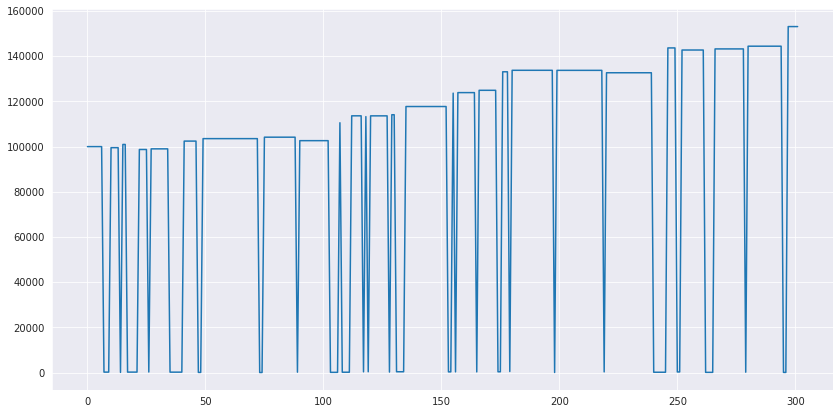

Финальный результат:  153116.58 руб.


In [ ]:
# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()
print('Финальный результат: ', round(money,2), 'руб.')

## **Блок тестирования модели по рисковой стратегии торговли**

In [ ]:
# Стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
riskIt = True

dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала

# Проходим по всему тестовому датасету
for i in range(test_dataset.shape[0]+1):
  tds = dataset[-xLen-10:].append(test_dataset[:i]).reset_index(drop=True) # Считываем очередное значение из тестового датасета
  # https://pythonru.com/uroki/osnovy-pandas-3-vazhnye-metody-formatirovanija-dannyh
  test = DerivativeData(tds, is_predict_test = True)
  net.scale_test_dataset(test)
  net.build_test_timeseries(xLen, batchSize)
  action = traide(model, net, riskIt) # Получаем действие, которое будем совершать

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money > tds.iloc[-1]['Close']:
    shares += money // tds.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции (покупаем целое количество (не обязательно))
    money = money % tds.iloc[-1]['Close'] # Считаем сколько осталось денег после покупки акций
    buyed = True
    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', tds.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * tds.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акций сбрасываем в 0
    buyed = False
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', tds.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('------------------------')  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег


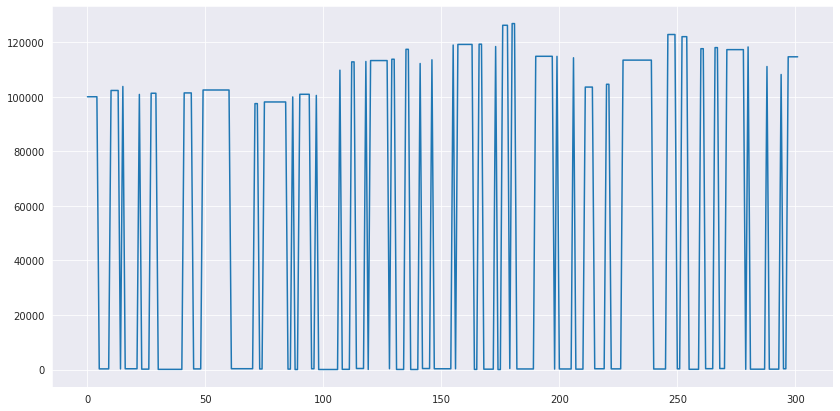

Финальный результат:  114646.55 руб.


In [ ]:
# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()
print('Финальный результат: ', round(money,2), 'руб.')